# Credit Risk Analysis
---

### Projeto 1: Desenvolvimento de um modelo de concessão de crédito.

**Objetivo:** desenvolver um modelo de concessão de crédito (classificação binária) usando as bases `train.gz`, `test.gz` e `oot.gz`.

**Etapas:**
1. Entendimento da base e análise exploratória dos dados;
2. Pré-processamento das variáveis;
3. Treinamento de um modelo de classificação binária;
4. Análise técnica da performance do modelo, medida sobre a base de Teste.

### Base de dados
A base contém 150 variáveis, a maioria das quais está mascarada. Utilize a coluna ID como uma key.

A variável alvo é denominada TARGET e possui os seguintes valores:

- 1: Mau Pagador, i.e. atraso > 60 dias em 2 meses.
- 0: Bom Pagador, i.e. caso contrário.
O score do modelo de classificação deve mapear a classe Bom Pagador.

A base de dados está contida na pasta ../datasets/credit_01 e é dividida em 3 partes:

* Treino: base usada para treinamento contendo dados de janeiro a agosto de 2017;

* Teste: base usada para testes contendo dados de janeiro a agosto de 2017;

* Out-of-time (oot): contém dados obtidos de setembro a novembro de 2017. A escoragem dessa base pode ser uma etapa do desafio, a depender das condições e requisitos combinados.

A base outoftime é considerada uma base "cega" por não possuir a variável "TARGET" (apenas a equipe do Prophet/Neurolake possui acesso a essa variável).

### Bibliotecas

In [1]:
# Data cleaning and wrangling
import pandas as pd
import numpy as np

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Validação de modelos
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV,  cross_validate, cross_val_score, StratifiedKFold, train_test_split # a base já vem separada em treino e test como arquivos diferentes

# Pré-processamento 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize, MinMaxScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Feature selection
from sklearn.feature_selection import chi2

# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Manter saída do processamento do sklearn como DataFrame Pandas
from sklearn import set_config
set_config(transform_output='pandas')

### Import de Datasets

In [2]:
CREDIT_TRAIN = pd.read_csv('../../datasets/credit_01/train.gz', compression='gzip')
CREDIT_TEST = pd.read_csv('../../datasets/credit_01/test.gz', compression='gzip')
CREDIT_OOT = pd.read_csv('../../datasets/credit_01/oot.gz', compression='gzip')

train_data = CREDIT_TRAIN
test_data = CREDIT_TEST
oot_data = CREDIT_OOT

In [3]:
train_data.shape

(120750, 151)

In [4]:
test_data.shape

(51751, 151)

In [5]:
oot_data.shape

(91965, 150)

## Data understand


In [6]:
# Modificando o nome do dataset para não influenciar na EDA
df_train = train_data 

In [7]:
df_train.head(3)

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,181755
1,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,287633
2,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,88015


Ao que parece:
- REF_DATE - Data
- VAR2 - Sexo
- VAR5 - Estado
- VAR6 - Latitude
- VAR7 - Longitude
- VAR148 - Email

In [8]:
# Exibir informações (pd.options.display.max_info_columns)
df_train.info(verbose=True, memory_usage='deep', show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Data columns (total 151 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    REF_DATE  120750 non-null  object 
 1    TARGET    120750 non-null  int64  
 2    VAR2      106131 non-null  object 
 3    IDADE     107040 non-null  float64
 4    VAR4      202 non-null     object 
 5    VAR5      117394 non-null  object 
 6    VAR6      117394 non-null  float64
 7    VAR7      117394 non-null  float64
 8    VAR8      67640 non-null   object 
 9    VAR9      117447 non-null  object 
 10   VAR10     117474 non-null  object 
 11   VAR11     74488 non-null   float64
 12   VAR12     65724 non-null   float64
 13   VAR13     15530 non-null   float64
 14   VAR14     95197 non-null   float64
 15   VAR15     58269 non-null   float64
 16   VAR16     44981 non-null   float64
 17   VAR17     15530 non-null   float64
 18   VAR18     95197 non-null   float64
 19   VAR19     58269 non-n

In [9]:
# Variáveis com mais nulos
df_train.isna().sum().sort_values(ascending=False).head(25)

VAR146    120582
VAR4      120548
VAR46     120456
VAR45     120456
VAR44     120349
VAR43     120349
VAR145    120071
VAR38     119981
VAR26     119742
VAR27     119708
VAR143    119174
VAR144    119174
VAR31     116833
VAR48     112338
VAR33     112129
VAR34     112129
VAR20     109397
VAR28     108031
VAR30     108031
VAR17     105220
VAR13     105220
VAR23     105220
VAR21     105157
VAR29      96026
VAR37      95706
dtype: int64

In [10]:
# Variáveis com menos nulos
df_train.isna().sum().sort_values(ascending=False).tail(15)

VAR136      2939
VAR132      2939
VAR131      2939
VAR137      2939
VAR138      2939
VAR142       165
VAR39         71
TARGET         0
REF_DATE       0
VAR47          0
VAR141         0
VAR147         0
VAR148         0
VAR149         0
ID             0
dtype: int64

Somente as variáveis TARGET, REF_DATE, VAR47, VAR141, VAR147, VAR148, VAR149 e ID não possuem nulos.

In [11]:
# Variáveis com apenas 1 valor (constante)
df_train.nunique().sort_values(ascending=False).tail(10)

VAR49     2
VAR48     2
VAR4      1
VAR36     1
VAR38     1
VAR33     1
VAR45     1
VAR43     1
VAR35     1
VAR149    1
dtype: int64

As variáveis VAR4, VAR33, VAR35, VAR36, VAR38, VAR43, VAR45, VAR149 possuem apenas 1 valor. 

In [12]:
# Análise descritiva das variáveis contínuas
df_train.describe()

,TARGET,IDADE,VAR6,VAR7,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,...,VAR41,VAR42,VAR44,VAR46,VAR47,VAR141,VAR145,VAR146,VAR147,ID
count,120750.000000,107040.000000,117394.000000,117394.000000,74488.000000,65724.000000,15530.000000,95197.000000,58269.000000,44981.000000,...,117811.000000,107048.000000,401.000000,294.000000,120750.000000,120750.000000,679.000000,168.000000,120750.000000,120750.000000
mean,0.245027,42.125255,-14.411389,-45.903480,0.235917,0.290241,0.313850,0.241245,0.185754,2.044374,...,0.631175,0.504619,1691.738429,6984.218469,0.256543,1854.833006,4018.743785,1942.649762,101.841656,165324.864199
std,0.430105,15.198476,8.995077,7.529788,0.625609,0.308937,0.241229,0.262687,0.195320,3.170869,...,0.222607,0.069614,2177.830516,4621.964093,0.406746,893.999792,3700.836248,3143.757850,0.540016,95488.442320
min,0.000000,18.014000,-33.521563,-72.900276,-4.000000,0.000000,0.000000,0.000000,0.000000,0.083333,...,0.000000,0.006658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,3.000000
25%,0.000000,30.057250,-22.842778,-49.903564,0.000000,0.055000,0.056000,0.105000,0.078000,0.250000,...,0.440572,0.463579,642.000000,3888.995000,0.000000,1513.227400,1633.195000,0.000000,102.000000,82727.250000
50%,0.000000,39.867000,-13.010590,-46.574908,0.000000,0.159000,0.318000,0.140000,0.112000,0.833333,...,0.542298,0.496036,769.000000,5386.310000,0.003000,1627.157652,3024.480000,935.120000,102.000000,165298.000000
75%,0.000000,52.997000,-6.357067,-39.023621,0.000000,0.505000,0.507000,0.168000,0.153000,2.416667,...,0.898052,0.522576,1747.500000,9601.390000,0.421000,1820.670284,5217.670000,2260.125000,102.000000,248248.000000
max,1.000000,105.477000,4.602823,-32.429516,4.000000,1.500000,1.000000,1.700000,1.000000,15.999999,...,1.000000,0.910865,17374.940000,26523.920000,1.000000,33954.140000,33954.140000,17229.200000,102.000000,330581.000000


A VAR11 vai de -4 a 4; e a VAR147 apresenta na sua maioria o valor 102.

As variáveis VAR6, VAR7 e VAR11 possuem valores negativos, porém, ao que parece as VAR6, VAR7 são dados de latitude e longitude e a VAR11 pode indicar uma categorização/score.

In [13]:
# Identificando categorias das colunas

categ_cols = df_train[['VAR11', 'VAR147']]

categ_per_column = {
    col: categ_cols[col].unique()
    for col in categ_cols.columns if categ_cols[col].nunique() >= 1 # filtrando por 3 ou mais categorias
}

# Exibindo as categorias
print("Categorias por coluna:")
for col, categories in categ_per_column.items():
    print(f"{col}: {list(categories)}")

Categorias por coluna:
VAR11: [np.float64(1.0), np.float64(0.0), np.float64(nan), np.float64(3.0), np.float64(2.0), np.float64(4.0), np.float64(-1.0), np.float64(-2.0), np.float64(-3.0), np.float64(-4.0)]
VAR147: [np.int64(102), np.int64(100)]


A VAR11 tem 9 valores e a VAR147 tem 2.

### Gráficos

<Axes: xlabel='IDADE', ylabel='Count'>

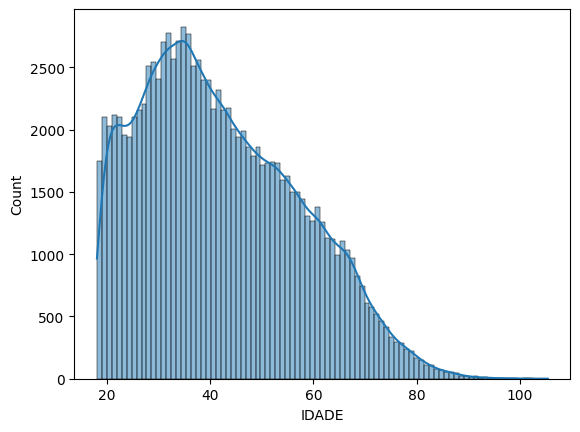

In [14]:
# Distribuição da idade
sns.histplot(df_train, x='IDADE', kde=True)

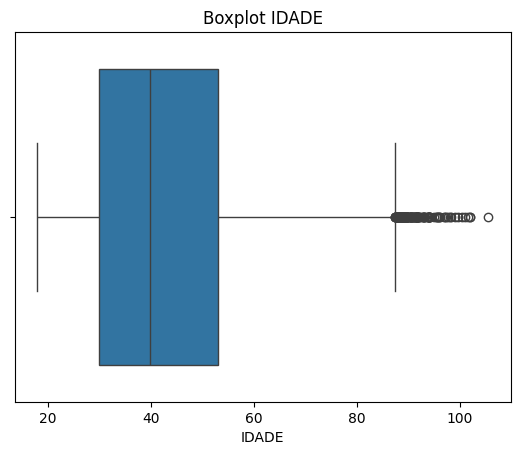

In [15]:
sns.boxplot(data=df_train, x='IDADE')
plt.title("Boxplot IDADE")
plt.show()

Grupo composto por pessoas com:
- Média de Idade: 42.12
- Mediana de Idade: 39.86



In [16]:
# Valores mínimos e máximos da data de referência
print(f"Referência antiga: {df_train['REF_DATE'].min()}")
print(f"Referência recente: {df_train['REF_DATE'].max()}")

Referência antiga: 2017-01-02 00:00:00+00:00
Referência recente: 2017-08-31 00:00:00+00:00


In [17]:
# Quantidade de casos de Target por Estado
df_train.groupby(by=['VAR5'])[['TARGET']].count()

,TARGET
VAR5,
AC,2304
AL,2800
AM,4145
AP,1292
BA,10306
CE,8262
DF,790
ES,2765
GO,2369


In [18]:
# Verificar os valores de TARGET por estado

if "VAR5" in df_train.columns and "TARGET" in df_train.columns:
    # Verificar valores únicos na coluna 'Estado' (opcional, para validação)
    print("Estados disponíveis:", df_train["VAR5"].unique())

    # Agregar os dados
    agregacao = df_train.groupby("VAR5")["TARGET"].value_counts().unstack(fill_value=0) # unstack preenche os estados sem registros específicos com 0

    # Renomear as colunas para clareza
    agregacao.columns = ["TARGET_0", "TARGET_1"]

    # Adicionar uma coluna com o total de observações por estado
    agregacao["Total"] = agregacao["TARGET_0"] + agregacao["TARGET_1"]
    
    # Calcular percentuais
    agregacao["Percentual_TARGET_0"] = (agregacao["TARGET_0"] / agregacao["Total"] * 100).round(2)
    agregacao["Percentual_TARGET_1"] = (agregacao["TARGET_1"] / agregacao["Total"] * 100).round(2)

    # Exibir o DataFrame resultante
    print(agregacao.sort_values(by='Percentual_TARGET_0', ascending=False))

Estados disponíveis: ['RO' 'PB' 'RS' 'BA' 'SP' 'MG' 'RJ' 'MS' 'PR' 'SC' 'RN' nan 'CE' 'AC' 'PE'
 'TO' 'AL' 'MT' 'ES' 'MA' 'AM' 'PI' 'DF' 'GO' 'PA' 'SE' 'RR' 'AP']
      TARGET_0  TARGET_1  Total  Percentual_TARGET_0  Percentual_TARGET_1
VAR5                                                                     
SC        1618       395   2013                80.38                19.62
MS        2014       501   2515                80.08                19.92
AC        1844       460   2304                80.03                19.97
MT        1609       406   2015                79.85                20.15
RO        1380       351   1731                79.72                20.28
PR        2907       761   3668                79.25                20.75
MG        6061      1696   7757                78.14                21.86
PI        1447       411   1858                77.88                22.12
RS        6544      1866   8410                77.81                22.19
TO         594       17

## Data preparation

Top 3 estados com **mais registros:**
1. SP
2. BA
3. PA
   
Top 3 estados com maior percentual de **melhor pagador:**
1. SC
2. MS
3. AC

Top 3 estados com maior percentual de **pior pagador** (gráfico abaixo):
1. AP
2. AL
3. RR



<Axes: xlabel='VAR5', ylabel='TARGET'>

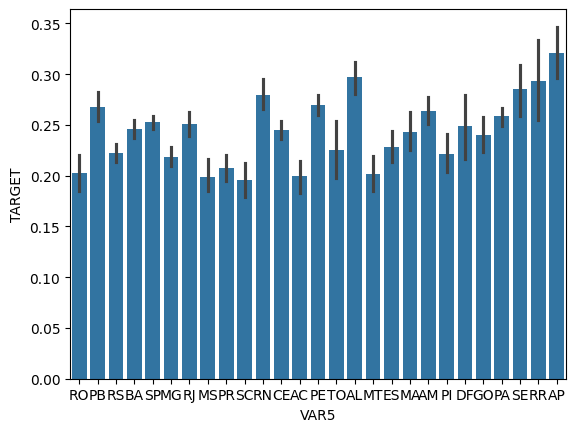

In [19]:
sns.barplot(df_train, x='VAR5', y='TARGET',)

In [20]:
df_train.groupby(by=['VAR2'])[['TARGET']].count()

,TARGET
VAR2,
F,60131
M,46000


In [21]:
# Verificar os valores de TARGET por estado

if "VAR2" in df_train.columns and "TARGET" in df_train.columns:
    # Verificar valores únicos na coluna 'Estado' (opcional, para validação)
    print("Sexo disponíveis:", df_train["VAR2"].unique())

    # Agregar os dados
    agrega = df_train.groupby("VAR2")["TARGET"].value_counts().unstack(fill_value=0) # unstack preenche os estados sem registros específicos com 0

    # Renomear as colunas para clareza
    agrega.columns = ["TARGET_0", "TARGET_1"]

    # Adicionar uma coluna com o total de observações por estado
    agrega["Total"] = agrega["TARGET_0"] + agrega["TARGET_1"]
    
    # Calcular percentuais
    agrega["Percentual_TARGET_0"] = (agrega["TARGET_0"] / agrega["Total"] * 100).round(2)
    agrega["Percentual_TARGET_1"] = (agrega["TARGET_1"] / agrega["Total"] * 100).round(2)

    # Exibir o DataFrame resultante
    print(agrega.sort_values(by='Total', ascending=False))

Sexo disponíveis: ['M' 'F' nan]
      TARGET_0  TARGET_1  Total  Percentual_TARGET_0  Percentual_TARGET_1
VAR2                                                                     
F        47360     12771  60131                78.76                21.24
M        33669     12331  46000                73.19                26.81


A maioria dos clientes são do sexo feminino, que também tem maior percentual de bom pagador.

<Axes: xlabel='VAR2', ylabel='TARGET'>

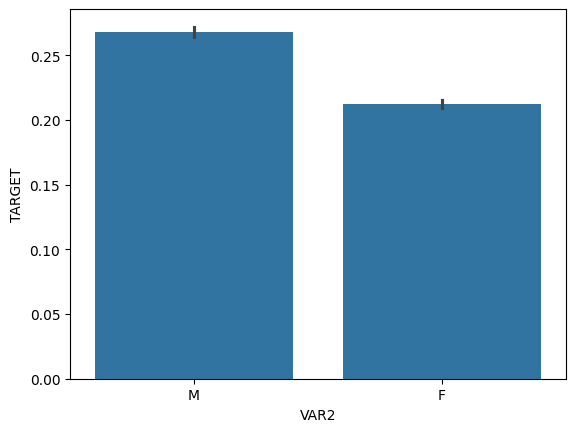

In [22]:
sns.barplot(df_train, x='VAR2', y='TARGET')

<Axes: xlabel='TARGET', ylabel='ID'>

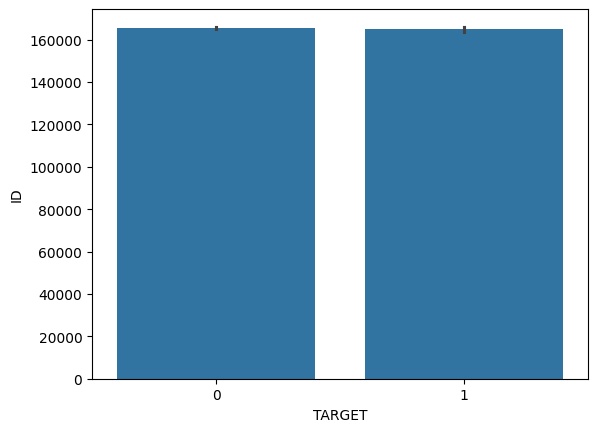

In [23]:
# Quantidade de casos de bom e mau pagador
sns.barplot(df_train, x='TARGET', y='ID')

### Pré-processamento dos dados

#### Remoção de colunas com mais de 50% de nulos

In [24]:
# drop colunas com mais de 50% de nulo
null_prop = train_data.isnull().mean()
remove_col = null_prop[null_prop > 0.5].index
train_data = train_data.drop(columns=remove_col)

print(train_data.info(verbose=True,show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Data columns (total 118 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    REF_DATE  120750 non-null  object 
 1    TARGET    120750 non-null  int64  
 2    VAR2      106131 non-null  object 
 3    IDADE     107040 non-null  float64
 4    VAR5      117394 non-null  object 
 5    VAR6      117394 non-null  float64
 6    VAR7      117394 non-null  float64
 7    VAR8      67640 non-null   object 
 8    VAR9      117447 non-null  object 
 9    VAR10     117474 non-null  object 
 10   VAR11     74488 non-null   float64
 11   VAR12     65724 non-null   float64
 12   VAR14     95197 non-null   float64
 13   VAR18     95197 non-null   float64
 14   VAR24     97285 non-null   float64
 15   VAR39     120679 non-null  float64
 16   VAR40     117466 non-null  float64
 17   VAR41     117811 non-null  float64
 18   VAR42     107048 non-null  float64
 19   VAR47     120750 non-

In [25]:
# set ID como index 
train_data = train_data.set_index('ID')

# drop colunas com pouca informação relevante
drop_cols = ['REF_DATE', 'VAR148', 'VAR149', 'VAR6', 'VAR7', 'VAR149']
train_data = train_data.drop(columns=drop_cols)
train_data

,TARGET,VAR2,IDADE,VAR5,VAR8,VAR9,VAR10,VAR11,VAR12,VAR14,...,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147
ID,,,,,,,,,,,,,,,,,,,,,
181755,0,M,34.137,RO,D,E,BAIXA,1.0,0.182,0.141,...,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102
287633,0,M,40.447,PB,E,E,MEDIA,0.0,NaN,0.136,...,MEDIO,PROXIMO,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102
88015,0,F,33.515,RS,NaN,E,ALTISSIMA,NaN,0.095,0.152,...,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102
122576,1,F,25.797,BA,E,E,MEDIA,0.0,0.359,0.014,...,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102
1272,0,F,54.074,RS,B,E,MEDIA,3.0,0.736,0.207,...,PROXIMO,MUITO PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,0,M,30.474,BA,E,E,ALTISSIMA,0.0,0.714,0.777,...,MUITO LONGE,LONGE,MEDIO,LONGE,LONGE,MUITO LONGE,MUITO LONGE,1752.116912,E,102
315754,0,F,19.570,SP,E,E,MEDIA,0.0,NaN,0.119,...,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,1510.234174,E,102
156370,0,M,32.882,SP,NaN,E,MEDIA,NaN,0.659,0.131,...,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,1736.106081,E,102


In [26]:
# separação de dados por tipo de coluna
target = 'TARGET'
num_cols = ['IDADE', 'VAR141', 'VAR39','VAR40','VAR41','VAR42','VAR47','VAR24','VAR18','VAR14', 'VAR12']
cat_cols = [col for col in train_data.columns if col not in num_cols + [target]]

### Remover outliers

In [27]:
# Função para remover outliers com base no IQR
def remove_outliers(df, num_cols):
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Aplicar a função para remover outliers
train_data = remove_outliers(train_data, num_cols)
test_data = remove_outliers(test_data, num_cols)

In [28]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,21711.0,0.177053,0.381722,0.000000,0.000000,0.000000,0.000000,1.000000
IDADE,21711.0,42.828132,14.440892,18.041000,31.277000,40.296000,53.074000,86.833000
VAR11,15346.0,0.023915,0.307209,-4.000000,0.000000,0.000000,0.000000,4.000000
VAR12,21711.0,0.155794,0.148381,0.000000,0.041000,0.118000,0.200000,0.627000
VAR14,21711.0,0.128840,0.032429,0.014000,0.103000,0.132000,0.154000,0.254000
VAR18,21711.0,1.037937,0.487879,0.002740,0.503899,1.172603,1.438356,2.449315
VAR24,21711.0,0.046844,0.050480,0.000000,0.000000,0.034000,0.069000,0.207000
VAR39,21711.0,0.453847,0.138864,0.108470,0.351907,0.448307,0.551678,0.832160
VAR40,21711.0,0.511004,0.096175,0.249189,0.440452,0.495860,0.565244,0.784260
VAR41,21711.0,0.587819,0.207522,0.000000,0.427771,0.505962,0.772303,0.981519


### Balanceando as classes

Utilização da técnica SMOTE

In [29]:
# Definir as variáveis categóricas e numéricas
num_cols = ['IDADE', 'VAR141', 'VAR39', 'VAR40', 'VAR41', 'VAR42', 'VAR47', 'VAR24', 'VAR18', 'VAR14', 'VAR12']
cat_cols = [col for col in train_data.columns if col not in num_cols + ['TARGET', 'ID']]  # Excluindo TARGET e ID

# Pipeline para dados numéricos
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # Substituir valores ausentes pela mediana
    ('scaler', MinMaxScaler())                      # Escalonar os dados numéricos
])

# Pipeline para dados categóricos
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Substituir valores ausentes pelo mais frequente
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))  # Codificação one-hot
])

# Combinação dos pipelines para pré-processamento
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Divisão do dataset em treino e teste
X_train = train_data.drop(columns=['TARGET'])
y_train = train_data['TARGET']

X_test = test_data.drop(columns=['TARGET'])
y_test = test_data['TARGET']

# Criar instância do SMOTE
smote = SMOTE(random_state=42)

# 1. Ajustar os dados com o pré-processamento
X_train_transformed = preprocessor.fit_transform(X_train)

# 2. Aplicar SMOTE ao conjunto de treino (após o pré-processamento)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

# Agora X_train_res e y_train_res têm o mesmo número de amostras para ambas as classes


In [30]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['IDADE', 'VAR141', 'VAR39', 'VAR40', 'VAR41',
                                  'VAR42', 'VAR47', 'VAR24', 'VAR18', 'VAR14',
                                  'VAR12']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['VAR2', 'VAR5', 'VAR8', 'VAR9', 'VAR10',
                                  'VAR11', 'VAR49', 'VAR50', 'VAR51', 'VAR52',
                                  'VAR53', 'VAR54', 'VAR55', 'VAR56', 'VAR57',
                                  'VAR58', 'VAR59', 'VAR60', 'VAR61', 'VAR62',
                                  'VAR63', 'VAR64', 'VAR65', 'VAR66', 'VAR67',
                                  'VAR68', 'VAR69', 'VAR70', 'VAR71', 'VAR72', ...])])

In [ ]:
# CÓDIGO APLICADO ANTES DE TRATAR OUTLIER E BALANCEAMENTO

""" 
# Divisão do dataset em treino e teste
X_train = train_data.drop(columns=['TARGET'])
y_train = train_data[['TARGET']]

X_test = test_data.drop(columns=['TARGET'])
y_test = test_data[['TARGET']]

# Pipeline para dados numéricos
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),   # Substituir valores ausentes pela média
    ('scaler', MinMaxScaler())                  # Escalonar os dados
])

# Pipeline para dados categóricos
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Substituir valores ausentes pelo mais frequente (moda)
    ('encoder', OneHotEncoder(drop='if_binary',handle_unknown='ignore', sparse_output=False))    # Codificação one-hot
])

# Combinação dos pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

preprocessor
"""


" \n# Divisão do dataset em treino e teste\nX_train = train_data.drop(columns=['TARGET'])\ny_train = train_data[['TARGET']]\n\nX_test = test_data.drop(columns=['TARGET'])\ny_test = test_data[['TARGET']]\n\n# Pipeline para dados numéricos\nnum_pipeline = Pipeline([\n    ('imputer', SimpleImputer(strategy='median')),   # Substituir valores ausentes pela média\n    ('scaler', MinMaxScaler())                  # Escalonar os dados\n])\n\n# Pipeline para dados categóricos\ncat_pipeline = Pipeline([\n    ('imputer', SimpleImputer(strategy='most_frequent')),  # Substituir valores ausentes pelo mais frequente (moda)\n    ('encoder', OneHotEncoder(drop='if_binary',handle_unknown='ignore', sparse_output=False))    # Codificação one-hot\n])\n\n# Combinação dos pipelines\npreprocessor = ColumnTransformer([\n    ('num', num_pipeline, num_cols),\n    ('cat', cat_pipeline, cat_cols)\n])\n\npreprocessor\n"

## Modeling

In [32]:
# Lista de modelos para treinamento
models = {
    'DummyClassifier': DummyClassifier(strategy='most_frequent'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LGBMClassifier': LGBMClassifier()
}

In [ ]:
# CÓDIGO APLICADO ANTES DE TRATAR OUTLIER E BALANCEAMENTO

"""
# Resultado das métricas para cada modelo
results = []

# Binarizar as classes (necessário para ROC AUC se multiclass)
if len(y_train.nunique()) > 2:
    y_test_binarized = label_binarize(y_test, classes=y_train.nunique())
else:
    y_test_binarized = y_test

# Iterar sobre os modelos e treinar
for name, model in models.items():
    print(f"\nTreinando modelo: {name}")
    
    # Criar o pipeline com o modelo específico
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Pré-processamento
        ('classifier', model)           # Modelo atual
    ])
    
    # Treinar o modelo
    model_pipeline.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = model_pipeline.predict(X_test)
    
    # Previsões de probabilidades (necessário para ROC AUC)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1] if hasattr(model_pipeline, "predict_proba") else None
    
    # Calcular as métricas
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted' if len(y_train.nunique()) > 2 else 'binary'),
        'Recall': recall_score(y_test, y_pred, average='weighted' if len(y_train.nunique()) > 2 else 'binary'),
        'Precision': precision_score(y_test, y_pred, average='weighted' if len(y_train.nunique()) > 2 else 'binary'),
        'ROC AUC': roc_auc_score(y_test_binarized, y_proba) if y_proba is not None else 'N/A'
    }
    
    # Adicionar os resultados à lista
    results.append(metrics)
    print(f"Métricas do {name}: {metrics}")

# Exibir os resultados finais

results_df = pd.DataFrame(results)
print("\nResultados Finais:")
print(results_df)
"""

'\n# Resultado das métricas para cada modelo\nresults = []\n\n# Binarizar as classes (necessário para ROC AUC se multiclass)\nif len(y_train.nunique()) > 2:\n    y_test_binarized = label_binarize(y_test, classes=y_train.nunique())\nelse:\n    y_test_binarized = y_test\n\n# Iterar sobre os modelos e treinar\nfor name, model in models.items():\n    print(f"\nTreinando modelo: {name}")\n    \n    # Criar o pipeline com o modelo específico\n    model_pipeline = Pipeline([\n        (\'preprocessor\', preprocessor),  # Pré-processamento\n        (\'classifier\', model)           # Modelo atual\n    ])\n    \n    # Treinar o modelo\n    model_pipeline.fit(X_train, y_train)\n    \n    # Fazer previsões no conjunto de teste\n    y_pred = model_pipeline.predict(X_test)\n    \n    # Previsões de probabilidades (necessário para ROC AUC)\n    y_proba = model_pipeline.predict_proba(X_test)[:, 1] if hasattr(model_pipeline, "predict_proba") else None\n    \n    # Calcular as métricas\n    metrics = {\

In [34]:
# Lista para armazenar os resultados das métricas
results = []

# Binarizar as classes se o problema for multiclasse
if y_train.nunique() > 2:  # Corrigido: Não usa len(), apenas compara com 2
    # Caso de múltiplas classes, binarizar as classes
    y_test_binarized = label_binarize(y_test, classes=y_train.unique())
else:
    # Caso de duas classes, não precisa binarizar
    y_test_binarized = y_test

# Iterar sobre os modelos e treinar
for name, model in models.items():
    print(f"\nTreinando modelo: {name}")
    
    # Criar o pipeline com o pré-processamento e o modelo atual
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Pré-processamento
        ('classifier', model)            # Modelo atual
    ])
    
    # Treinar o modelo
    model_pipeline.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = model_pipeline.predict(X_test)
    
    # Previsões de probabilidades (necessário para ROC AUC)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1] if hasattr(model_pipeline, "predict_proba") else None
    
    # Calcular as métricas de avaliação
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted' if y_train.nunique() > 2 else 'binary'),
        'Recall': recall_score(y_test, y_pred, average='weighted' if y_train.nunique() > 2 else 'binary'),
        'Precision': precision_score(y_test, y_pred, average='weighted' if y_train.nunique() > 2 else 'binary'),
        'ROC AUC': roc_auc_score(y_test_binarized, y_proba) if y_proba is not None else 'N/A'
    }
    
    # Adicionar as métricas à lista
    results.append(metrics)
    print(f"Métricas do {name}: {metrics}")

# Exibir os resultados finais
results_df = pd.DataFrame(results)
print("\nResultados Finais:")
print(results_df)



Treinando modelo: DummyClassifier


c:\Users\eudes\anaconda3\envs\neurolake\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Métricas do DummyClassifier: {'Model': 'DummyClassifier', 'Accuracy': 0.8231871565564055, 'Balanced Accuracy': np.float64(0.5), 'F1 Score': np.float64(0.0), 'Recall': np.float64(0.0), 'Precision': np.float64(0.0), 'ROC AUC': np.float64(0.5)}

Treinando modelo: LogisticRegression
Métricas do LogisticRegression: {'Model': 'LogisticRegression', 'Accuracy': 0.8228639155263442, 'Balanced Accuracy': np.float64(0.5024353845024901), 'F1 Score': np.float64(0.013205282112845138), 'Recall': np.float64(0.006703229737964655), 'Precision': np.float64(0.44), 'ROC AUC': np.float64(0.6192508079928278)}

Treinando modelo: RandomForestClassifier
Métricas do RandomForestClassifier: {'Model': 'RandomForestClassifier', 'Accuracy': 0.8229716625363647, 'Balanced Accuracy': np.float64(0.5077642686907166), 'F1 Score': np.float64(0.03861907548273844), 'Recall': np.float64(0.02010968921389397), 'Precision': np.float64(0.4852941176470588), 'ROC AUC': np.float64(0.6000858243122091)}

Treinando modelo: DecisionTreeC

c:\Users\eudes\anaconda3\envs\neurolake\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Métricas do XGBClassifier: {'Model': 'XGBClassifier', 'Accuracy': 0.8129511906044607, 'Balanced Accuracy': np.float64(0.5184251876808612), 'F1 Score': np.float64(0.10607621009268794), 'Recall': np.float64(0.0627666057282145), 'Precision': np.float64(0.34219269102990035), 'ROC AUC': np.float64(0.5965257504841576)}

Treinando modelo: LGBMClassifier
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3844, number of negative: 17867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3123
[LightGBM] [Info] Number of data points in the train set: 21711, number of used features: 400
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177053 -> initscore=-1.536442
[LightGBM] [Info] Start training from score -1.536442
Métricas do L

Nesse resultado após a remoção de outliers e o balanceamento das classes obtivemos que o modelo RandomForestClassifier teve o melhor desempenho global, com uma acurácia balanceada de 0.509, ROC AUC de 0.601, e uma precisão relativamente alta. 

Embora o DummyClassifier tenha uma acurácia mais alta, isso se deve provavelmente à sua simplicidade e não à sua capacidade de prever corretamente as classes.

Desse modo, RandomForestClassifier se destaca em termos de capacidade de discriminação entre as classes, mesmo com algumas limitações nas métricas de Recall e F1 Score.

Seguimos com a tunnagem dos hiperparâmetros para verificar se o modelo consegue melhorar.

### Tunning de hiperparâmetros

In [35]:
# Definindo os hiperparâmetros para o GridSearch (incluindo todos os modelos)
param_grid = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear', 'saga']
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [5, 10, 15],
        'classifier__min_samples_split': [2, 5]
    },
    'XGBClassifier': {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6, 10]
    },
    'LGBMClassifier': {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__num_leaves': [31, 50, 100]
    },
    'DecisionTreeClassifier': {
        'classifier__max_depth': [5, 10, 15],
        'classifier__min_samples_split': [2, 5]
    },
    'DummyClassifier': {
        'classifier__strategy': ['most_frequent', 'stratified', 'uniform', 'constant'],
        'classifier__constant': [0, 1]  # Para o caso de 'constant'
    }
}

# Lista de modelos para treinamento (todos os modelos agora, incluindo o DecisionTree e DummyClassifier)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LGBMClassifier': LGBMClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'DummyClassifier': DummyClassifier(strategy='most_frequent')
}

# Lista para armazenar os resultados das métricas
results = []

# Iterar sobre os modelos e realizar GridSearchCV
for model_name, model in models.items():
    print(f"\nRealizando GridSearchCV para o modelo: {model_name}")
    
    # Criar o pipeline com o pré-processamento e o modelo atual
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Pré-processamento
        ('classifier', model)            # Modelo atual
    ])
    
    # Definir o GridSearchCV com os parâmetros do modelo específico
    grid_search = GridSearchCV(
        model_pipeline,
        param_grid[model_name],  # Parâmetros para o modelo atual
        cv=3,  # Cross-validation
        n_jobs=-1,  # Usar todos os núcleos do processador
        scoring='f1_micro',  # Métrica de avaliação trocada de accuracy para f1_micro
        verbose=2,  # Nível de verbosidade
        error_score='raise'   # Levantar erro para depuração
    )
    
    # Treinar o modelo com o GridSearchCV
    try:
        grid_search.fit(X_train, y_train)
    except ValueError as e:
        print(f"Erro no modelo {model_name}: {e}")
        continue
    
    # Melhor modelo e melhores parâmetros
    print(f"Melhores parâmetros para {model_name}: {grid_search.best_params_}")
    print(f"Melhor score para {model_name}: {grid_search.best_score_}")
    
    # Avaliar o modelo com os melhores parâmetro



Realizando GridSearchCV para o modelo: LogisticRegression
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Melhores parâmetros para LogisticRegression: {'classifier__C': 0.01, 'classifier__solver': 'liblinear'}
Melhor score para LogisticRegression: 0.8229468932799042

Realizando GridSearchCV para o modelo: RandomForestClassifier
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\eudes\anaconda3\envs\neurolake\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros para RandomForestClassifier: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Melhor score para RandomForestClassifier: 0.8229468932799042

Realizando GridSearchCV para o modelo: XGBClassifier
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\eudes\anaconda3\envs\neurolake\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores parâmetros para XGBClassifier: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Melhor score para XGBClassifier: 0.8229929528810281

Realizando GridSearchCV para o modelo: LGBMClassifier
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3844, number of negative: 17867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3123
[LightGBM] [Info] Number of data points in the train set: 21711, number of used features: 400
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177053 -> initscore=-1.536442
[LightGBM] [Info] Start training from score -1.536442
[LightGBM] [Warning] No further splits with positive gain

## Evaluation

### Resultados dos modelos ANTES do tratamento de outliers e balanceamento de classes

Os resultados dos modelos apresentaram valores pouco confiáveis em relação às métricas avaliadas. A acurácia de 75% parece boa, mas a acurácia balanceada de 50% sugere que o modelo não está discriminando bem as classes (vide DummyClassifier). 

Os modelos com XGBClassifier e LGBMClassifier são ligeiramente mais eficazes em discriminar entre as classes, embora ainda precisem de melhorias. Os resultados da AUC_ROC sugere pouca capacidade discriminativa (menor que 0.7).

#### Conjunto de dados
O conjunto de dados precisa ser tratado para desbalanceamento de classes. O alto valor da Acurácia pode ter sido impactada pelo desbalanceamento, uma vez que as demais métricas como acurácia balanceada e f1 score estão mais baixas.

#### Avaliação de melhorias

Sendo assim, avalio que é necessário: 
- Remoção de outliers;
- Ajustar o desbalanceamento da base de dados.

### Resultados dos modelos APÓS o tratamento de outliers e balanceamento de classes

Após o tratamento de outliers e balanceamento de classes os resultados apresentaram resultados um pouco maiores, contudo mesmo após a tunagem os resultados não apresentaram alto desempenho dos modelos. 

O RandomForestClassifier teve o melhor desempenho global. Contudo seu desempenho é considerado fraco com uma Balanced Accuracy de 0.509, ROC AUC de 0.601 (range de 0.5 a 0.7 = fraco).

#### Avaliação Final de melhorias

Para melhorar o desempenho do modelo algumas etapas podem ser testadas:
- Incluir uma etapa de feature selection com análise pelo teste do chi-quadrado para variáveis categóricas (V de Cramer, Phi) e possível análise de PCA para variáveis contínuas;
- Validação cruzada.